In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, erfinv
import emcee
import corner

%matplotlib inline

## Part (a) -- drawing samples from Chabrier IMF by using emcee 

In [2]:
### probabilites here
def lnlike(M):
    return np.sum(np.log(0.15/M)-(np.log10(M)-np.log10(0.08))**2/(2*0.69**2))

def lnprior(M):
    # let's assume flat priors
    if 0.5 < M < 0.8:
        return 0.0
    return -np.inf

def lnprob(M):
    lp = lnprior(M)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(M)

def chabrier_imf(N, M_min, M_max):
    '''Analytical form of Chabrier IMF'''
    m = np.logspace(np.log10(M_min), np.log10(M_max), N)
    return 0.15/m * np.exp(-(np.log10(m)-np.log10(0.08))**2/(2*0.69**2))

In [3]:
### now let's draw some samples
ndim, nwalkers = 1, 100
pos = [np.array([np.random.uniform(0.5,0.8)]) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
pos1, prob, state = sampler.run_mcmc(pos, 1000);
sampler.reset()
sampler.run_mcmc(pos1, 100, rstate0=state);

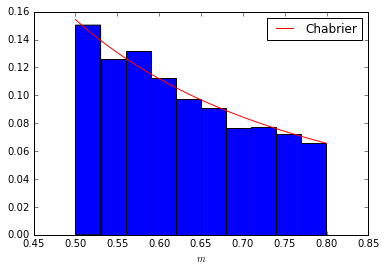

In [8]:
bins = np.logspace(np.log10(0.5),np.log10(0.8),1000)
weights = np.ones_like(sampler.flatchain)/len(sampler.flatchain)
plt.hist(sampler.flatchain, weights=weights)
plt.plot(bins, chabrier_imf(1000,0.5,0.8), c='r', label='Chabrier')
plt.legend()
plt.xlabel('$m$')
plt.show()

## Part (b)

We'll use the samples from part (a) and fit a single-slope power law using code from Problem 2.

In [9]:
samples = sampler.flatchain
print len(samples)

10000


In [10]:
### probabilites here
def lnlike2(theta, M_min, M_max, M):
    alpha = theta
    norm = (1.-alpha)/(M_max**(1.-alpha) - M_min**(1.-alpha))
    return np.sum(np.log(norm) - alpha * np.log(M))

def lnprior2(theta):
    alpha = theta
    # let's assume flat priors
    if 1.0 < alpha < 6.0:
        return 0.0
    return -np.inf

def lnprob2(theta, M_min, M_max, M):
    lp = lnprior2(theta)
    ll = lnlike2(theta, M_min, M_max, M)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll

In [18]:
### now let's set up emcee
ndim, nwalkers = 1, 100
pos = [np.array([2.]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
#pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=[0.5, 0.8, samples])
pos1, prob, state = sampler2.run_mcmc(pos, 1000);
sampler.reset()
sampler.run_mcmc(pos1, 2000, rstate0=state);

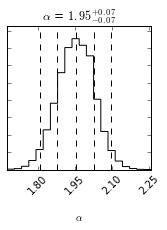

In [19]:
### corner plot
samples2 = sampler2.chain[:,:, :].reshape((-1, ndim))
fig3 = corner.corner(samples2, labels=[r"$\alpha$"], quantiles=[0.025, 0.16, 0.5, 0.84, 0.975], show_titles=True, \
                     truths=[2.3])
plt.show(fig3)

This result is different from the Kroupa index of 2.3 -- in fact, we can see from the plot that the Kroupa index is cleary outside the 1 $\sigma$ confidence interval (also outside the 3 $\sigma$ interval).